In [1]:
#import ROOT
import uproot
from IPython.display import display

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import subprocess
import os
import glob

from scipy.special import erf
import scipy.optimize as opt
from matplotlib.ticker import FixedLocator
from scipy.stats import norm
from matplotlib.ticker import FuncFormatter


# Easter TEST

- 14:47:58 (10 mm) start move in
- 14:50:14 (24.56mm)
- 14:57:41 (36.4 mm)
- 14:59:00 (36.2 mm)
- 14:59:30 : sto pADT
- 15:01:33: restart adt , lowe intensity 
- 15:04:30: dettector a little out (35.01)
- 15:07:12: crystal rotated 
- 15:07:50: started angular scan 
- 15:11:00 finished angular scan 
- 15:11:24 crystal rotated bachk to 4907
- 15:13:55: detctor fully out

In [4]:


hist = file_name['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EventSizePerStreamProc']

# Get bin contents and edges
values = hist.values()
edges = hist.axes[0].edges()

# Plot
plt.step(edges[:-1], values, where="mid", label=hist.title)
plt.xlabel("Processing Time [ms]")
plt.title(f"Histogram: {hist.title}")
plt.grid(True)
plt.legend()
plt.show()

TypeError: string indices must be integers

In [ ]:
file.keys()

['Histogramming;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms_recent;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits_recent;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us_recent;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EbDataCollectionTime_ms;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EbDataCollectionTime_ms_recent;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EventLifeTime_ms;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EventLifeTime_ms_recent;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EventLocation;1',
 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/EventOwnershipTime_ms;1',
 

In [ ]:
# Loop through all keys in the file
for key, obj in file.items():
    print(f"Key: {key}")
    print(f"  Type: {type(obj)}")

    # If it's a TTree, print its branches
    if isinstance(obj, uproot.behaviors.TTree.TTree):
        print("  Branches:")
        for branch in obj.keys():
            print(f"    - {branch}")



    print()

Key: Histogramming;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG;1
  Type: <class 'uproot.reading.ReadOnlyDirectory'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DataCollectionTime_ms_recent;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcAvailableCredits_recent;1
  Type: <class 'uproot.models.TH.Model_TH1I_v3'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us;1
  Type: <class 'uproot.models.TH.Model_TH2I_v4'>

Key: Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/DcResponseTime_us_recent;1
  Type: <class 'uproot.m

In [6]:
def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)
 
def get_name_by_time(hour, minute):
    minute = str(minute).zfill(2)
    hour = str(hour).zfill(2)
    path = f"../TFT/tmp_gnams/r1745147836_*-2025-04-20-{hour}-{minute}_*.root"
    files = glob.glob(path)
    if not files:
        raise FileNotFoundError(f"No file found for the specified time: {hour}:{minute}")
    fn = files[0]
    return fn

def get_values_minute(hour, minute, comulative = False):
    try:
        fn = get_name_by_time(hour, minute) 
        file = uproot.open(fn)
        hist = file['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks']
        values = hist.values()    
        if not comulative and not (hour == 13 and minute == 17):
            minute_before = minute - 1 if minute > 0 else 59
            hour_before = hour - 1 if minute == 0 else hour
            try:
                fn_before = get_name_by_time(hour_before, minute_before) 
                hist_before = uproot.open(fn_before)['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks']
                values_before = hist_before.values()
                values = values - values_before
            except FileNotFoundError:
                print(f"Warning: File for {hour_before}:{minute_before} not found. Skipping subtraction.")
                return None, None
        return hist, values
    except FileNotFoundError as e:
        print(e)
        return None, None
    

    
def plot_TFT_tracks(time, comulative = False):

    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour

    
    hist, values = get_values_minute(hour, minute, comulative)
    if values is None:
        return

    start = hour * 60 + minute
    end = last_hour * 60 + last_minute

    for t in range(start +1, end +1):
        h = t // 60
        m = t % 60

        hist_, values_ = get_values_minute(h, m, comulative)
        if values_ is not None:
            values += values_
            # 14 paticles missing due to not in file 14:43

    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 
    
    fig, ax = plt.subplots(figsize=(10,6.5))
    ALFA_x, ALFA_y = get_pentagonal()
    ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.tick_params(axis='both', which='major', labelsize=12)
    #cumu_str = " - cumulative" if comulative else ""
    if comulative:
        hour = 13
        minute = 17
    ax.text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour}:{minute} - {last_hour}:{last_minute}", ha="left", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
    #ax.text(0.1, 0.95,  f"Time {hour}:{minute}", ha="left", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

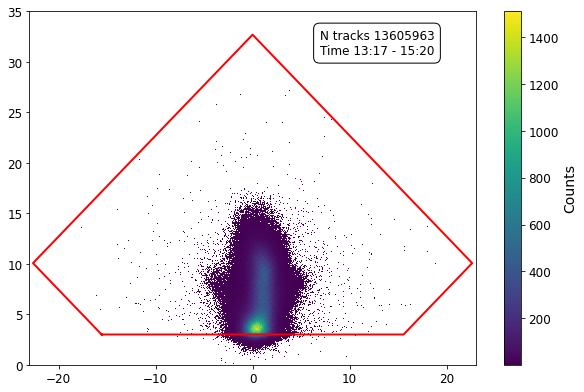

In [7]:
plot_TFT_tracks((15,20), comulative = True)

No file found for the specified time: 13:24
No file found for the specified time: 14:04
No file found for the specified time: 14:43


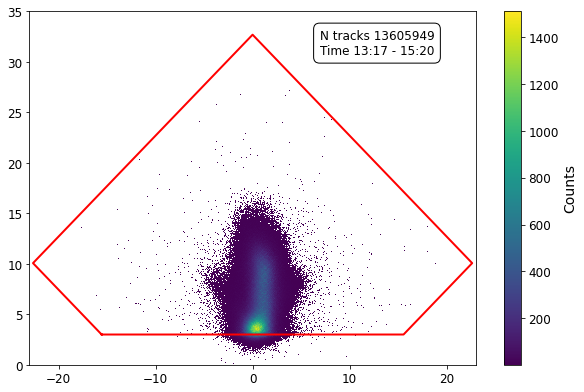

In [8]:
plot_TFT_tracks([(13,17), (15,20)])

No file found for the specified time: 13:24
No file found for the specified time: 14:04
No file found for the specified time: 14:43


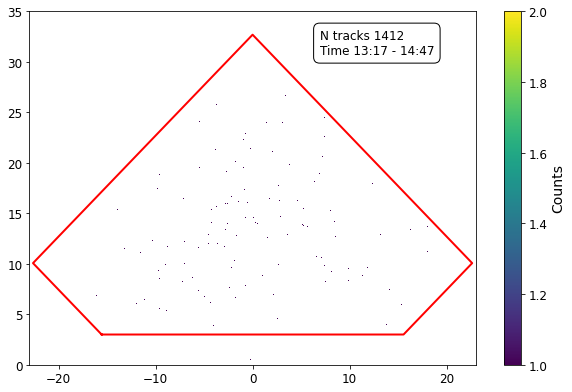

In [9]:
# Detector Out, taking backgound
plot_TFT_tracks([(13,17), (14,47)])

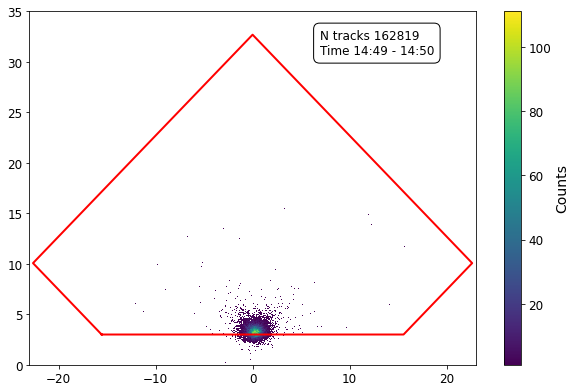

In [108]:
#Start moving 14:47 - 14:49
# FIRST TOUCH  at 24 mm
plot_TFT_tracks([(14,49), (14,50)])

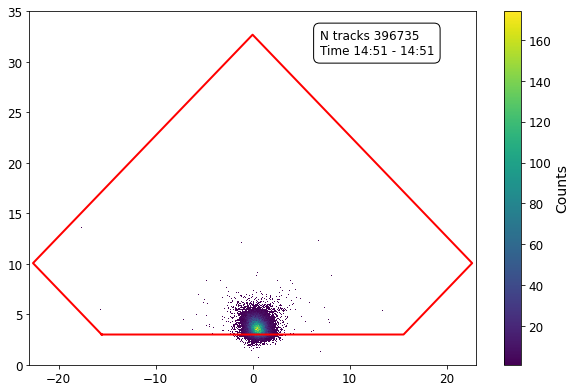

In [ ]:
# moving more
plot_TFT_tracks((14,51))

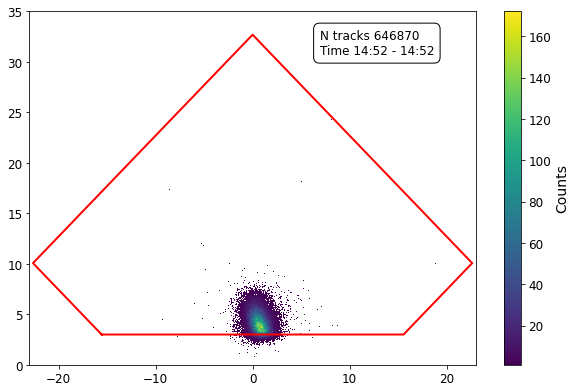

In [109]:
plot_TFT_tracks((14,52))

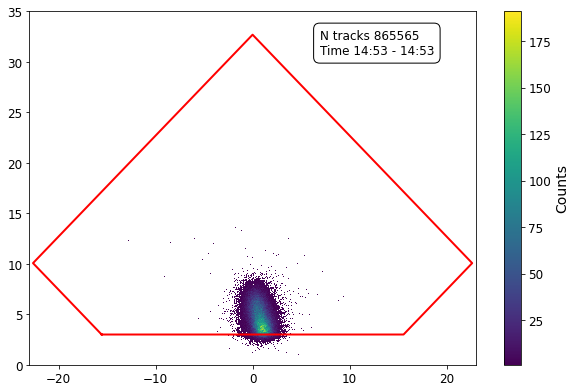

In [110]:
plot_TFT_tracks((14,53))

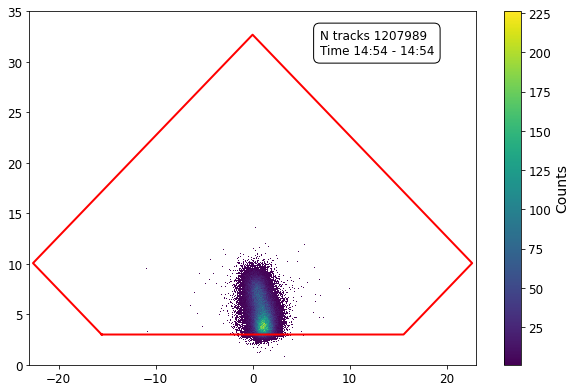

In [111]:
plot_TFT_tracks((14,54))

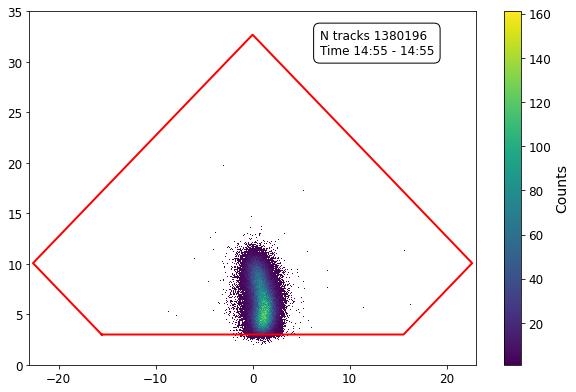

In [5]:
plot_TFT_tracks((14,55))

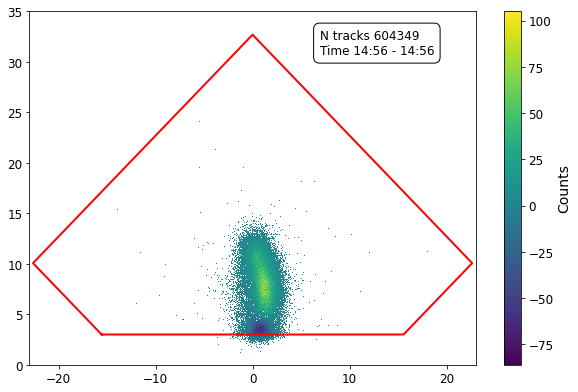

In [113]:
plot_TFT_tracks((14,56))

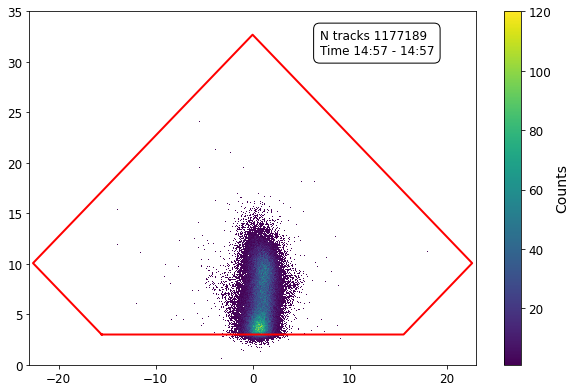

In [114]:
plot_TFT_tracks((14,57))

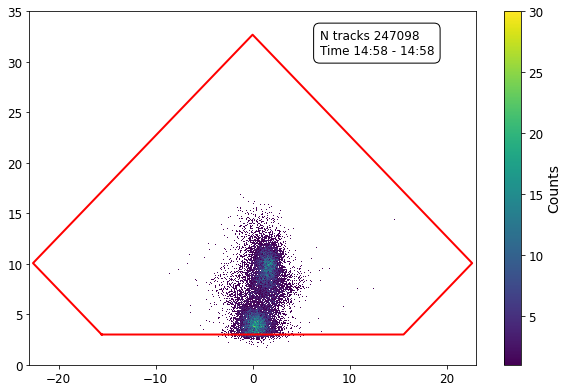

In [115]:
plot_TFT_tracks((14,58))

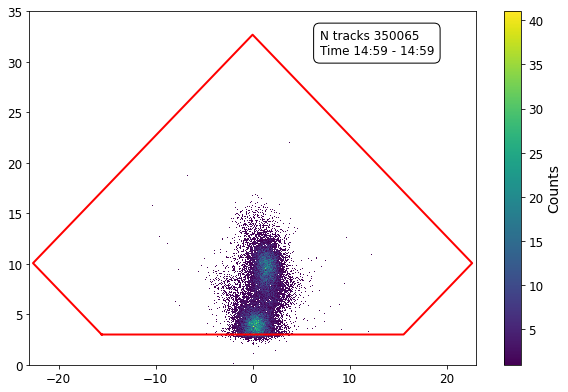

In [116]:
plot_TFT_tracks((14,59))

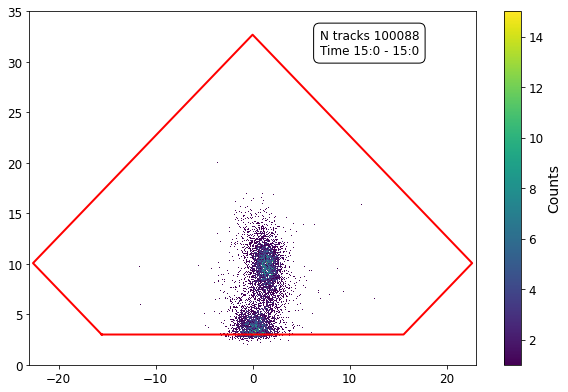

In [ ]:
# ADT OFF 
plot_TFT_tracks((15,00))

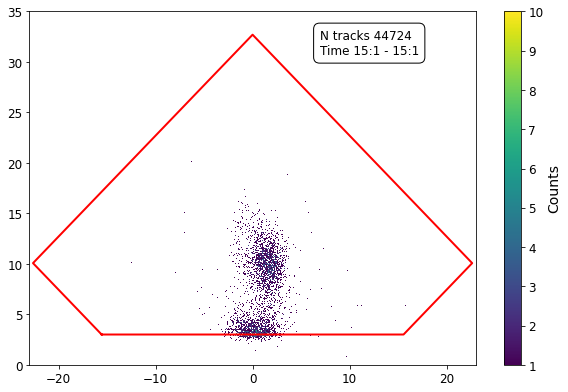

In [ ]:
# ADT OFF
plot_TFT_tracks((15,1))

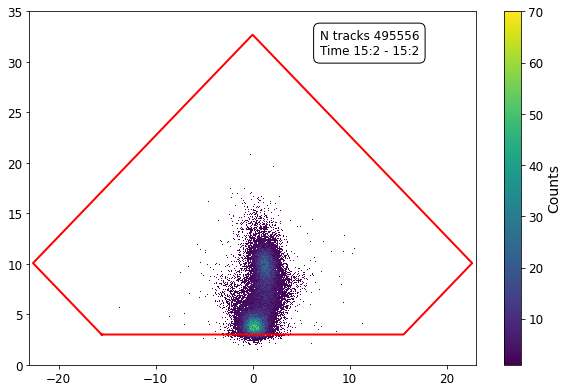

In [119]:
plot_TFT_tracks((15,2))

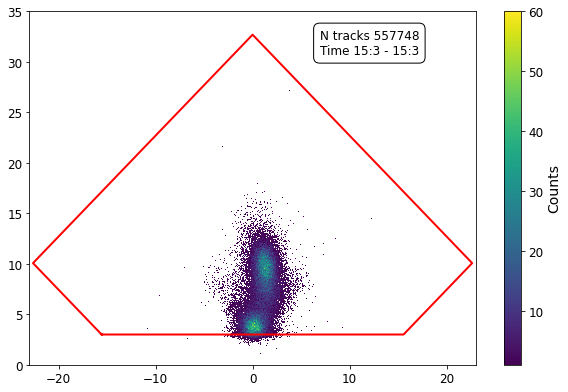

In [120]:
plot_TFT_tracks((15,3))

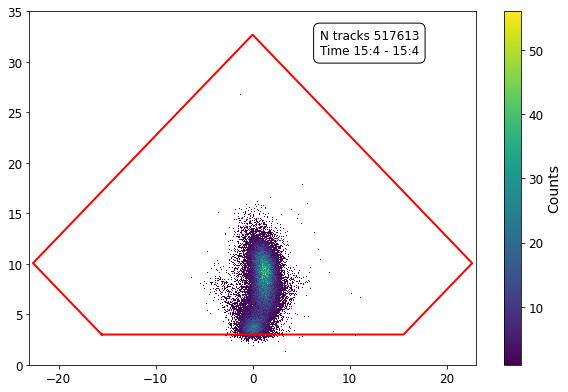

In [121]:
plot_TFT_tracks((15,4))

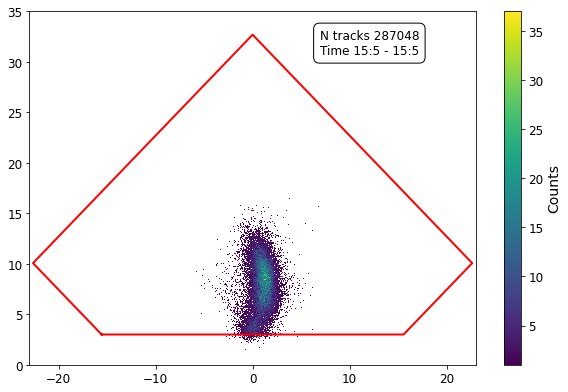

In [122]:
plot_TFT_tracks((15,5))

In [ ]:
## !! LHC.BSRT.5L4.B2:AVERAGE_EMITTANCE_H


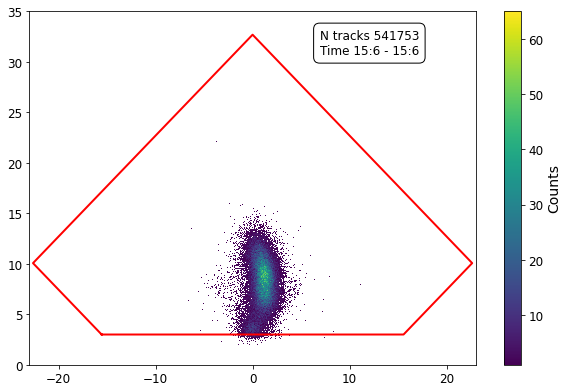

In [ ]:
## !!
plot_TFT_tracks((15,6))

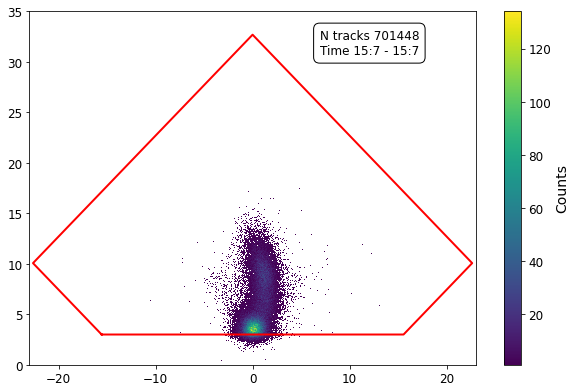

In [124]:
plot_TFT_tracks((15,7))

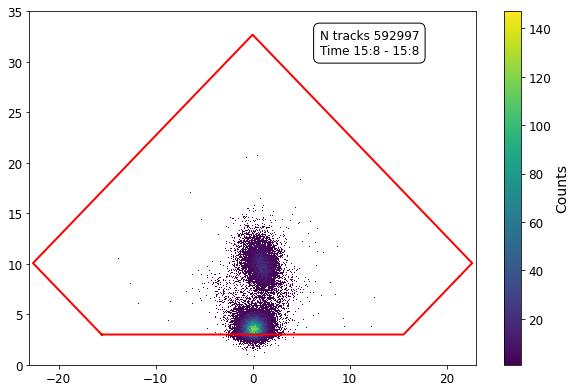

In [125]:
plot_TFT_tracks((15,8))

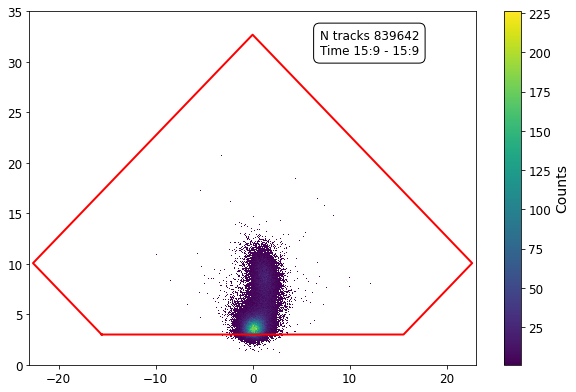

In [126]:
plot_TFT_tracks((15,9))

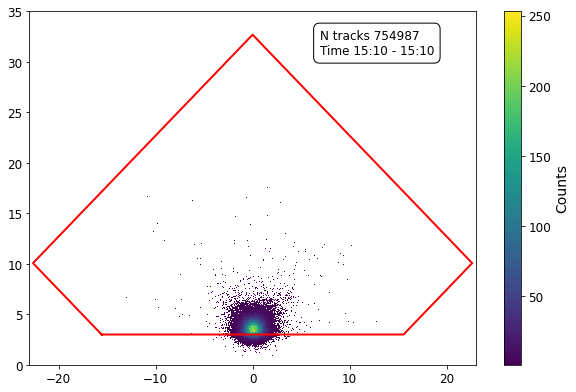

In [127]:
plot_TFT_tracks((15,10))

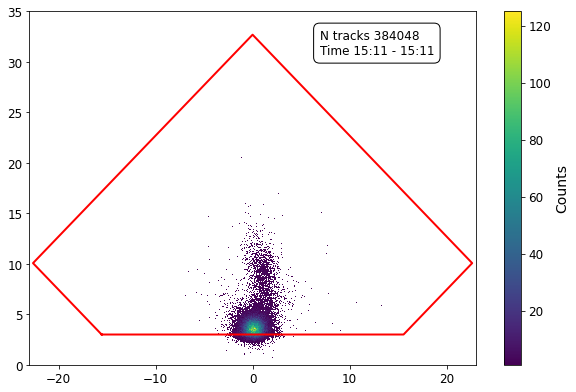

In [128]:
plot_TFT_tracks((15,11))

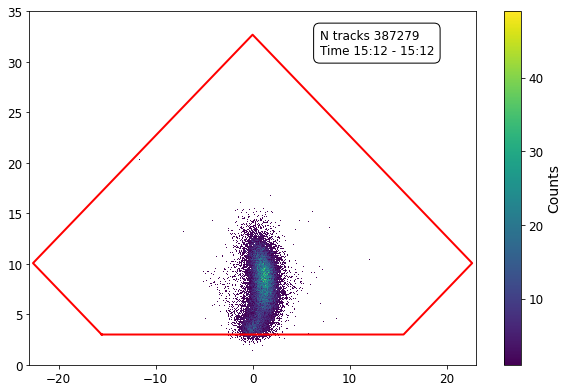

In [6]:
plot_TFT_tracks((15,12))

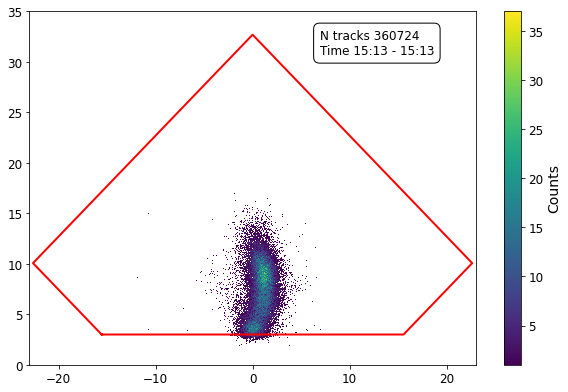

In [130]:
plot_TFT_tracks((15,13))

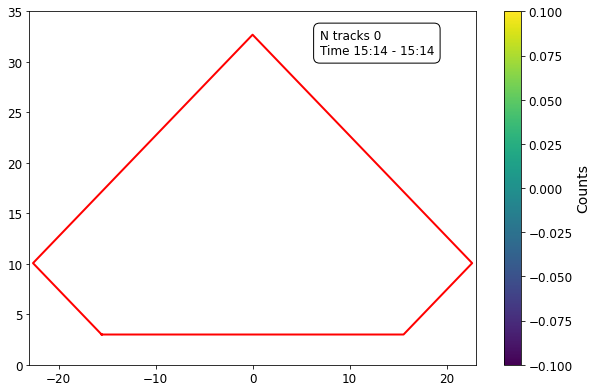

In [131]:
plot_TFT_tracks((15,14))

In [8]:
def get_pentagonal(y_lim = 0):
    y_lim = y_lim + 0.003
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    # Close the pentagon by appending the first vertex at the end
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    # Center in x an apply vertical offset
    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)
 
def get_name_by_time(hour, minute):
    minute = str(minute).zfill(2)
    hour = str(hour).zfill(2)
    path = f"../TFT/tmp_gnams/r1745147836_*-2025-04-20-{hour}-{minute}_*.root"
    files = glob.glob(path)
    if not files:
        raise FileNotFoundError(f"No file found for the specified time: {hour}:{minute}")
    fn = files[0]
    return fn

def get_values_minute(hour, minute, comulative = False):
    try:
        fn = get_name_by_time(hour, minute) 
        file = uproot.open(fn)
        hist = file['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks']
        values = hist.values()    
        if not comulative and not (hour == 13 and minute == 17):
            minute_before = minute - 1 if minute > 0 else 59
            hour_before = hour - 1 if minute == 0 else hour
            try:
                fn_before = get_name_by_time(hour_before, minute_before) 
                hist_before = uproot.open(fn_before)['Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/TFT_ReconstructedTracks']
                values_before = hist_before.values()
                values = values - values_before
            except FileNotFoundError:
                print(f"Warning: File for {hour_before}:{minute_before} not found. Skipping subtraction.")
                return None, None
        return hist, values
    except FileNotFoundError as e:
        print(e)
        return None, None
    

def get_tracks(time, comulative = False):

    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour

    
    hist, values = get_values_minute(hour, minute, comulative)
    if values is None:
        return

    start = hour * 60 + minute
    end = last_hour * 60 + last_minute

    for t in range(start +1, end +1):
        h = t // 60
        m = t % 60

        hist_, values_ = get_values_minute(h, m, comulative)
        if values_ is not None:
            values += values_
            # 14 paticles missing due to not in file 14:43

    edges_x = hist.axis(0).edges() 
    edges_y = hist.axis(1).edges() 

    return values, edges_x, edges_y

    
def plot_TFT_tracks(time, comulative = False, z_max = None):

    values, edges_x, edges_y = get_tracks(time, comulative)
    if values is None:
        return
    
    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour
    fig, ax = plt.subplots(figsize=(10,6.5))
    ALFA_x, ALFA_y = get_pentagonal()
    ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax.pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, vmax = z_max)  
    cbar = plt.colorbar(pcm, ax=ax)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax.tick_params(axis='both', which='major', labelsize=12)
    #cumu_str = " - cumulative" if comulative else ""
    if comulative:
        hour = 13
        minute = 17
    ax.text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
    #ax.text(0.1, 0.95,  f"Time {hour}:{minute}", ha="left", va="top", transform=ax.transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

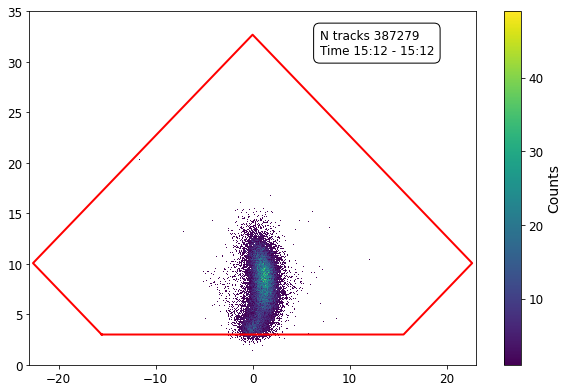

In [9]:
plot_TFT_tracks((15,12))

In [10]:
# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

def plot_Tracks_old(time, comulative = False, y_lower=None, y_upper=None, z_max = None):
    
    values, edges_x, edges_y = get_tracks(time, comulative)
    if values is None:
        return

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax[0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, vmax=z_max)  
    ALFA_x, ALFA_y = get_pentagonal()
    ax[0].plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    cbar = plt.colorbar(pcm, ax=ax[0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0].set_xlabel("x [mm]", fontsize=14)
    ax[0].set_ylabel("y [mm]", fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=12)
    ax[0].grid(linestyle=":")
    max_value = np.max(masked_values)
    print("Maximum value in the bins:", max_value)
    bin_width_x = np.diff(edges_x)[0]  # Assuming uniform bin widths
    print("Bin width along x-axis:", bin_width_x)
    bin_width_y = np.diff(edges_y)[0]  # Assuming uniform bin widths
    print("Bin width along y-axis:", bin_width_y)

    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour f"{h:02d}:{m:02d}"
    if comulative:
        hour = 13
        minute = 17
    ax[0].text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax[0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))


    values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection_uproot = np.sum(values_with_overflow, axis=0) 

    bin_centers = (edges_y[:-1] + edges_y[1:]) / 2
    ax[1].bar(edges_y[:-1], y_projection_uproot, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[1].set_xlabel("y [mm]", fontsize=14)
    ax[1].set_ylabel("Counts", fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=12)

    num_entries = np.sum(y_projection_uproot)
    edges = bin_centers #edges_y[1:] edges_y[:-1]
    mean = np.sum(edges* y_projection_uproot) / num_entries
    variance = np.sum(y_projection_uproot * (edges - mean) ** 2) / num_entries
    std_dev = np.sqrt(variance)
    legend_text = f"Entries: {num_entries}\nMean: {mean:.2f}\nStd Dev: {std_dev:.2f}"
    #ax[1].text(0.3, 0.95, legend_text, ha="right", va="top", transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))


    if y_lower is not None and y_upper is not None:
        y_centers = 0.5 * (edges_y[:-1] + edges_y[1:])  
        y_mask = (y_centers >= y_lower) & (y_centers <= y_upper)
        values_filtered = values[:, y_mask]  
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]


        ax[0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Extract bin centers
        x_centers = 0.5 * (edges_x[:-1] + edges_x[1:])
        y_centers = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])

        # Create a 2D meshgrid
        X, Y = np.meshgrid(x_centers, y_centers, indexing="ij")  # Ensure correct shape

        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]

        initial_guess = (np.max(zdata), np.mean(x_centers), np.mean(y_centers), np.std(x_centers), np.std(y_centers))

        # Fit the 2D Gaussian function
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")


       # Compute Y Projection (Summing over x-axis)
        y_projection = np.sum(values_filtered, axis=0)  # Sum over x-axis
        bin_centers = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])  # Compute bin centers
        # Generate Gaussian curve over the same y range
        y_fit = np.linspace(np.min(bin_centers), np.max(bin_centers), 100)
        #y_fit = np.linspace(np.min(edges_y), np.max(edges_y), 100)
        gaussian_curve = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  # Use A=1 temporarily

        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral = np.sum(y_projection * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral = np.trapz(gaussian_curve, y_fit)  # Integral of Gaussian using trapezoidal rule

        A_rescaled = hist_integral / gaussian_integral  # Rescale amplitude properly

        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve = gaussian_1d(y_fit, A_rescaled, y0_fit, sigma_y_fit)
        ax[1].plot(y_fit, gaussian_curve, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        #ax[1].axvline(y0_fit, color="red", linestyle="--", label="Mean")
        ax[1].axvline(y_upper)
        ax[1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm"
        ax[1].text(0.3, 0.95, legend_text, ha="right", va="top", transform=ax[1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))


In [11]:
def plot_Tracks(time, comulative = False, y_lower=None, y_upper=None, absolute_y_pos= 0, 
                z_max_2D = None, z_max_y = None, z_max_x = None,  normalize = False, print_info = False):
    
    values, edges_x, edges_y = get_tracks(time, comulative)
    if values is None:
        return
    
    edges_y = edges_y + absolute_y_pos
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    pcm = ax[0][0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, vmax=z_max_2D)  
    ALFA_x, ALFA_y = get_pentagonal(absolute_y_pos*1e-3)
    ax[0][0].plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    cbar = plt.colorbar(pcm, ax=ax[0][0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0][0].set_xlabel("x [mm]", fontsize=14)
    ax[0][0].set_ylabel("y [mm]", fontsize=14)
    ax[0][0].tick_params(axis='both', which='major', labelsize=12)
    ax[0][0].grid(linestyle=":")
    max_value = np.max(masked_values)
    bin_width_x = np.diff(edges_x)[0]  # Assuming uniform bin widths
    bin_width_y = np.diff(edges_y)[0]  # Assuming uniform bin widths

    if isinstance(time, list):
        hour, minute = time[0][0], time[0][1]
        last_hour, last_minute = time[1][0], time[1][1]
    else:
        hour, minute = time[0], time[1]
        last_minute = minute  #+ 1 if minute < 59 else 0
        last_hour = hour # + 1 if minute == 59 else hour f"{h:02d}:{m:02d}"
    if comulative:
        hour = 13
        minute = 17
    ax[0][0].text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax[0][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    #values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection = np.sum(values, axis=0) 
    bin_centers_y = (edges_y[:-1] + edges_y[1:]) / 2
    ax[0][1].bar(edges_y[:-1], y_projection, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[0][1].set_xlabel("y [mm]", fontsize=14)
    ax[0][1].set_ylabel("Counts", fontsize=14)
    ax[0][1].tick_params(axis='both', which='major', labelsize=12)
    if z_max_y is not None:
        ax[0][1].set_ylim(0, z_max_y)

    x_projection = np.sum(values, axis=1)  # sum over y → projection along x
    bin_centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])  # Compute bin centers
    ax[1][0].bar(edges_x[:-1], x_projection, width=np.diff(edges_x), align="edge", alpha=0.6)
    ax[1][0].set_xlabel("x [mm]", fontsize=14)
    ax[1][0].set_ylabel("Counts", fontsize=14)
    ax[1][0].tick_params(axis='both', which='major', labelsize=12)
    if z_max_x is not None:
        ax[1][0].set_ylim(0, z_max_x)

    if print_info:
        print("Maximum value in the bins:", max_value)
        print("Bin width along y-axis:", bin_width_y)
        print("Bin width along x-axis:", bin_width_x)
        print("Maximum in x projection:", np.max(x_projection))
        print("Maximum in y projection:", np.max(y_projection))


    cumulative_y_projection = np.cumsum(np.array(y_projection)[::-1])[::-1]
    if normalize:
        cumulative_y_projection = cumulative_y_projection / np.max(cumulative_y_projection)
    ax[1][1].plot(edges_y[:-1], cumulative_y_projection, linewidth=2, label="Cumulative Y Projection")
    ax[1][1].tick_params(axis='both', which='major', labelsize=12)

    if y_lower is not None and y_upper is not None:

        # Filter in y
        y_mask = (bin_centers_y >= y_lower) & (bin_centers_y <= y_upper)
        values_filtered = values[:, y_mask] 
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]
        y_centers_filt = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])
        y_projection_filt = np.sum(values_filtered, axis=0)  # Sum over x-axis
        x_projection_filt = np.sum(values_filtered, axis=1)  # Sum over y-axis
        ax[0][0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0][0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Create a 2D meshgrid
        X, Y = np.meshgrid(bin_centers_x, y_centers_filt, indexing="ij")  # Ensure correct shape
        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]
        # Fit the 2D Gaussian function
        initial_guess = (np.max(zdata), np.mean(x_projection_filt), np.mean(y_projection_filt), np.std(x_projection_filt), np.std(x_projection_filt))
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"2D Gauss Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")
        #ax[0][0].plot(x0_fit, y0_fit, "ro", markersize=10, label="Fit center")

        # Compute Y Projection 
        y_fit = np.linspace(np.min(y_centers_filt), np.max(y_centers_filt), 100)
        gaussian_curve_y = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  #
        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral_y = np.sum(y_projection_filt * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral_y = np.trapz(gaussian_curve_y, y_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_y = hist_integral_y / gaussian_integral_y  # Rescale amplitude properly
        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve_y = gaussian_1d(y_fit, A_rescaled_y, y0_fit, sigma_y_fit)
        ax[0][1].plot(y_fit, gaussian_curve_y, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        ax[0][1].axvline(y_upper)
        ax[0][1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm\nFit sigma: {sigma_y_fit:.2f} mm"
        ax[0][1].text(0.75, 0.95, legend_text, ha="right", va="top", transform=ax[0][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        # Compute X fit 
        x_fit = np.linspace(np.min(bin_centers_x), np.max(bin_centers_x), 100)
        gaussian_curve_x = gaussian_1d(x_fit, 1, x0_fit, sigma_x_fit)  #
        hist_integral_x = np.sum(x_projection_filt * np.diff(edges_x))
        gaussian_integral_x = np.trapz(gaussian_curve_x, x_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_x = hist_integral_x / gaussian_integral_x  # Rescale amplitude properly
        gaussian_curve_x = gaussian_1d(x_fit, A_rescaled_x, x0_fit, sigma_x_fit)
        ax[1][0].plot(x_fit, gaussian_curve_x, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        legend_text = f"Fit mean: {x0_fit:.2f} mm"
        ax[1][0].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        ax[1][1].axvline(y_lower, color="red", linestyle="--", label="Mean")
        cum_to_fit_erf = cumulative_y_projection[edges_y[:-1] >= y_lower]
        y_to_fit_erf = edges_y[:-1][edges_y[:-1] >= y_lower]
        def erfunc(x,a,b,c,d):
            return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
        
        param0 = [np.max(cum_to_fit_erf), np.min(cum_to_fit_erf), np.mean(y_to_fit_erf), np.std(y_to_fit_erf)]
        params, extras = opt.curve_fit(erfunc, y_to_fit_erf, cum_to_fit_erf,  p0=param0)
        print("ERF Fit parameters:", params)
        ax[1][1].plot(edges_y[:-1], erfunc(edges_y[:-1], *params), linewidth=2, label="ERF Fit")
        legend_text = f"Fit mean: {params[2]:.2f} mm\nFit sigma: {params[3]:.2f} mm"
        ax[1][1].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
        


In [12]:
XRP_pos_max = 36.4e-3
n_sigma = 4.74802461105181

In [13]:
beta_XRP =290.95199237436066

energy = 450
mp = 0.9382
emittance_n = 3.5e-6
gamma = energy/mp
beta = np.sqrt(1-1/(gamma*gamma))
emittance = emittance_n/(beta*gamma)

sigma_XRP =  np.sqrt(emittance*beta_XRP)
sigma_XRP

0.0014570908107233269

In [14]:
XRP_pos_data = 35.1e-3
XRP_pos_data*n_sigma / XRP_pos_max

4.578452303514245

2D Gauss Fit Parameters:
 A=57.723534418875204, x0=1.1632984406607483, y0=23.51803361366292, sigma_x=-0.7098403493006796, sigma_y=1.9987369354852862
ERF Fit parameters: [ 3.71750616e+05 -7.43827568e+05  2.35508787e+01  2.02501682e+00]


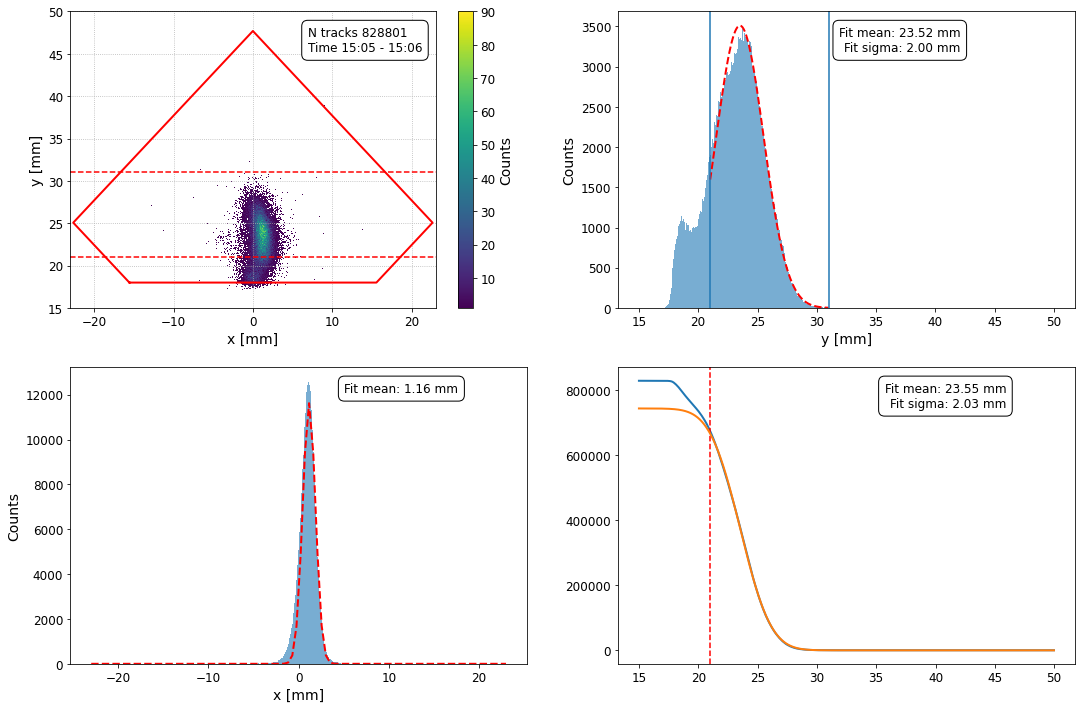

In [15]:
plot_Tracks([(15,5), (15,6)], y_lower= 21, y_upper= 31, z_max_2D = 90, normalize=False, absolute_y_pos=15)

2D Gauss Fit Parameters:
 A=24.14283189018042, x0=1.166488222516868, y0=8.434911669820394, sigma_x=-0.7391850716755319, sigma_y=2.1426106693739726
ERF Fit parameters: [ 1.70302774e+05 -3.40835447e+05  8.40726049e+00  2.12132835e+00]


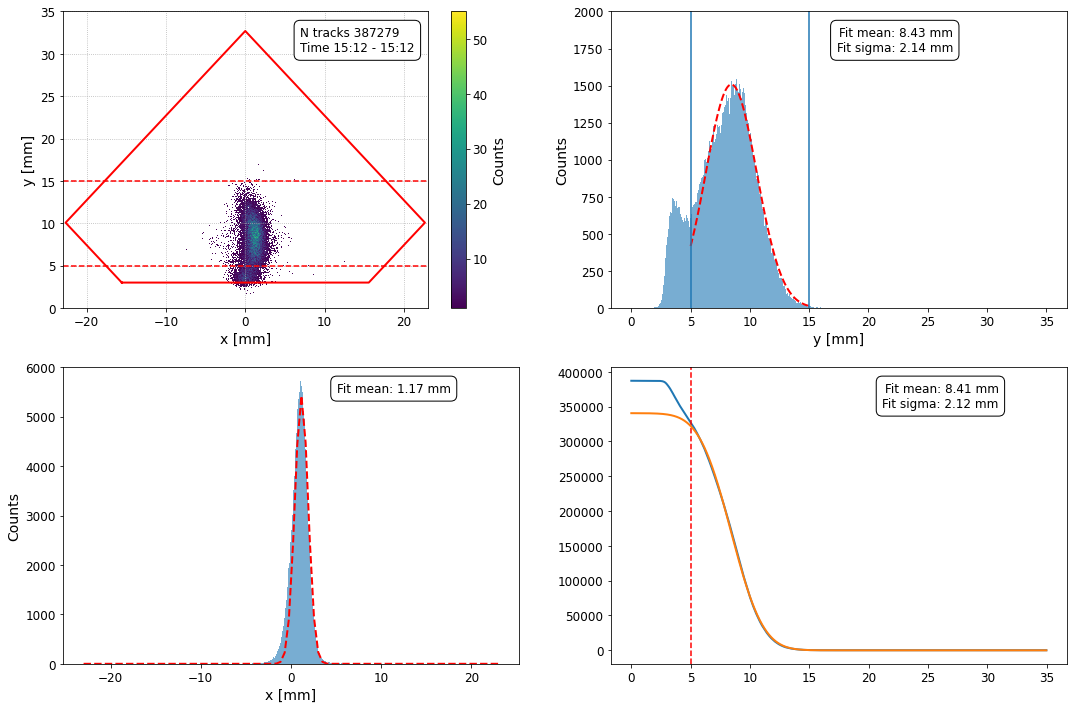

In [16]:
plot_Tracks((15, 12), y_lower= 5, y_upper= 15, z_max_2D = 55, z_max_y = 2000, z_max_x = 6000, normalize=False)

In [223]:
def find_maximum_values_in_interval(hour, minute, last_hour, last_minute, retur_dict  = False):
    start = hour * 60 + minute
    end = last_hour * 60 + last_minute

    bins_dict = {}

    for t in range(start +1, end +1):
        h = t // 60
        m = t % 60

        hist_, values_ = get_values_minute(h, m, False)
        time_str = f"{h:02d}:{m:02d}"
        if values_ is not None:
            proj_x = np.sum(values_, axis=1)  # sum over y → projection along x
            proj_y = np.sum(values_, axis=0)  # sum over x → projection along y
        else:
            proj_x = np.zeros_like(values_)
            proj_y = np.zeros_like(values_)
        tmp = {}
        tmp['max_bins'] = np.max(values_)
        tmp['sum_bins'] = np.sum(values_)
        tmp['max_y'] = np.max(proj_y)
        tmp['max_x'] = np.max(proj_x)
        bins_dict[time_str] =  tmp

    
    max_max_bins_key = max(bins_dict, key=lambda k: bins_dict[k]["max_bins"] if bins_dict[k]["max_bins"] is not None else 0)
    max_sum_bins_key = max(bins_dict, key=lambda k: bins_dict[k]["sum_bins"] if bins_dict[k]["sum_bins"] is not None else 0)
    max_max_y_key = max(bins_dict, key=lambda k: bins_dict[k]["max_y"] if bins_dict[k]["max_y"] is not None else 0)
    max_max_x_key = max(bins_dict, key=lambda k: bins_dict[k]["max_x"] if bins_dict[k]["max_x"] is not None else 0)

    max_max_bins_value = bins_dict[max_max_bins_key]["max_bins"]
    max_sum_bins_value = bins_dict[max_sum_bins_key]["sum_bins"]
    max_max_y_value = bins_dict[max_max_y_key]["max_y"]
    max_max_x_value = bins_dict[max_max_x_key]["max_x"]

    print("\n\nMax of max_bins:", max_max_bins_value, "at key:", max_max_bins_key)
    print("Max of sum_bins:", max_sum_bins_value, "at key:", max_sum_bins_key)
    print("Max of max_y:", max_max_y_value, "at key:", max_max_y_key)
    print("Max of max_x:", max_max_x_value, "at key:", max_max_x_key)

    if retur_dict:
        return bins_dict

In [85]:
hour, minute = 13, 17
last_hour, last_minute = 15, 20
bins_dict = find_maximum_values_in_interval(hour, minute, last_hour, last_minute, retur_dict = True)

No file found for the specified time: 13:24
No file found for the specified time: 14:04
No file found for the specified time: 14:43
Max of max_bins: 253 at key: 15:10
Max of sum_bins: 1380196 at key: 14:55
Max of max_y: 11733 at key: 15:10
Max of max_x: 23430 at key: 14:55


/tmp/cmaccani/ipykernel_15745/3177451911.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,6.5))


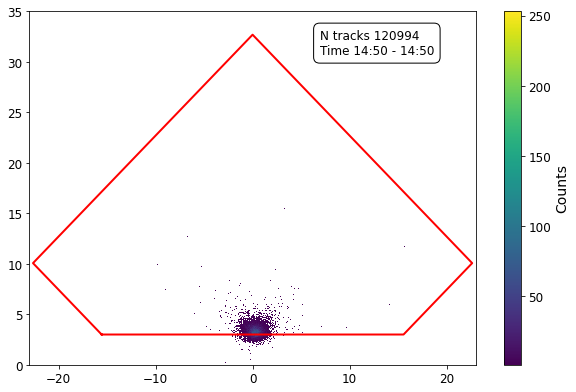

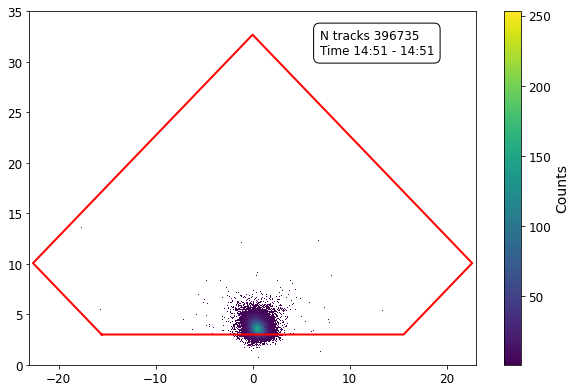

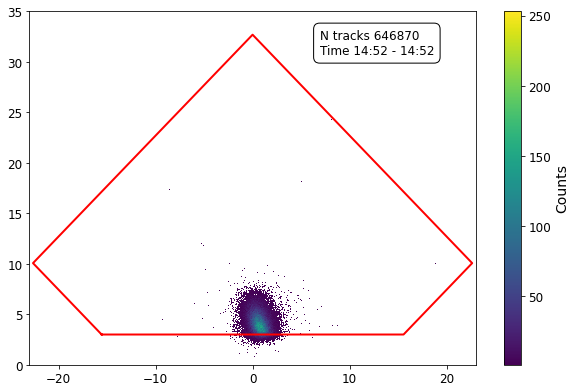

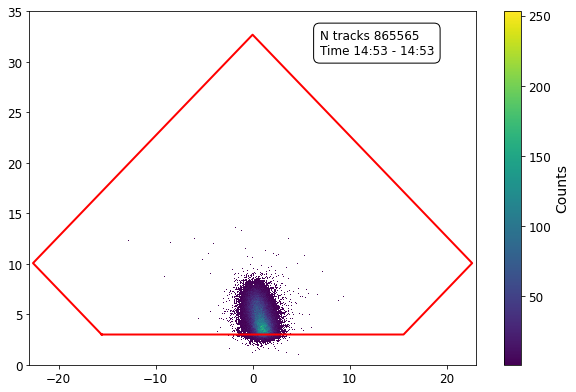

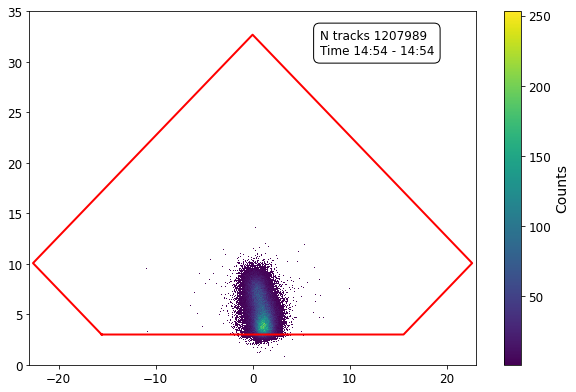

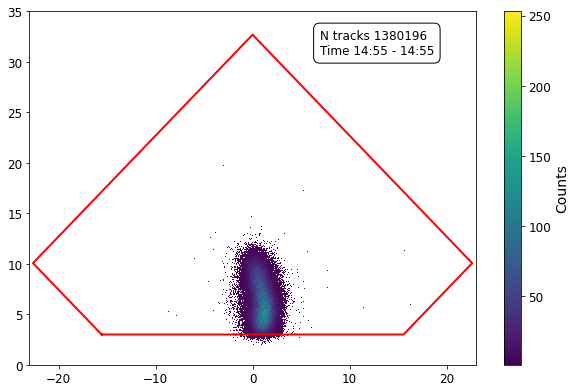

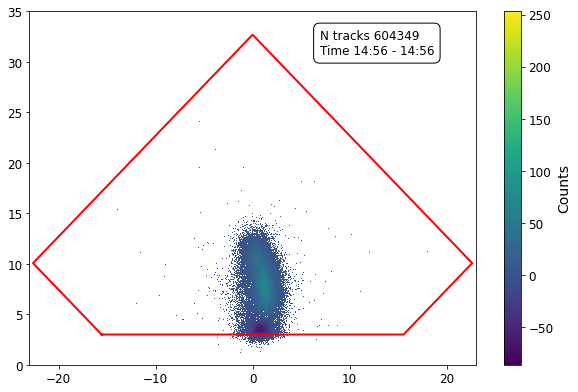

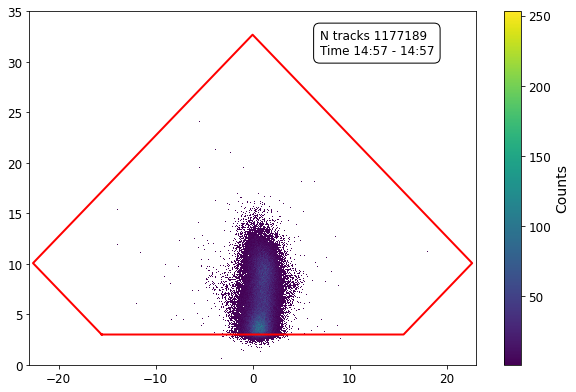

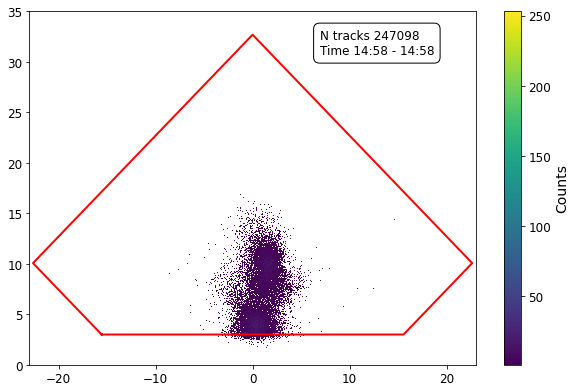

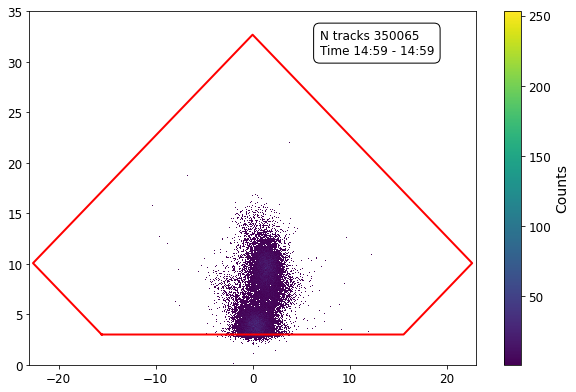

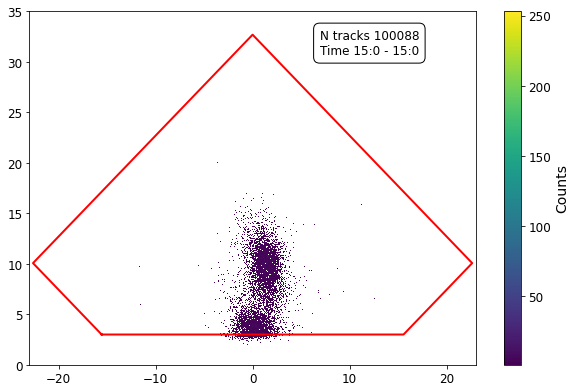

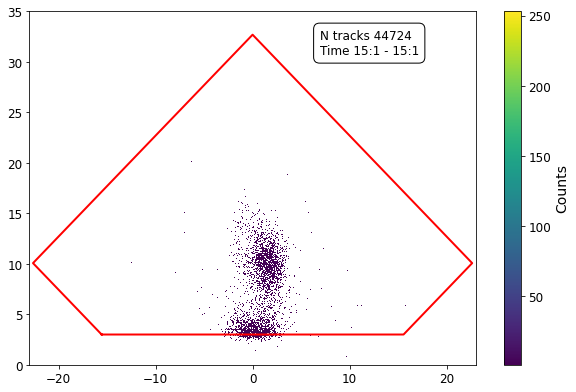

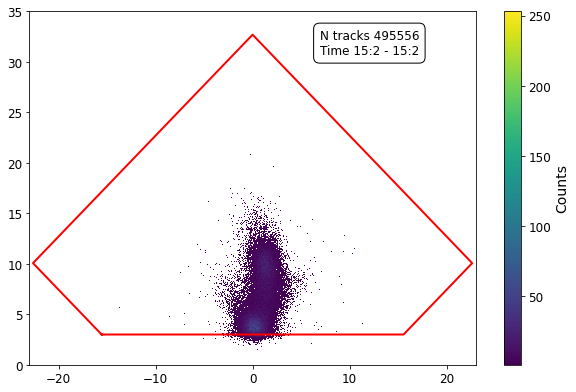

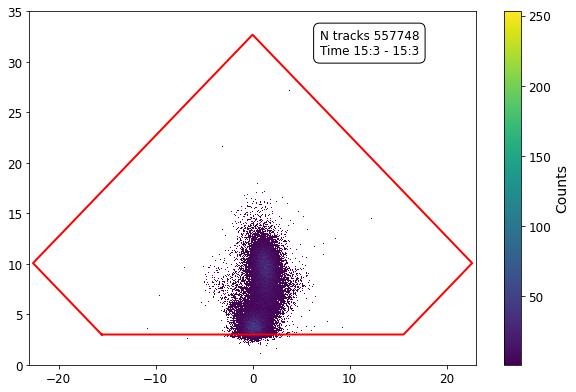

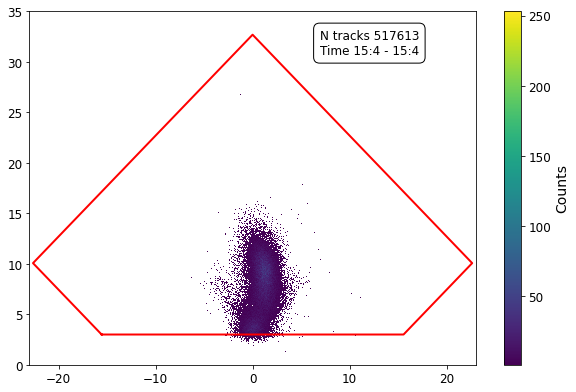

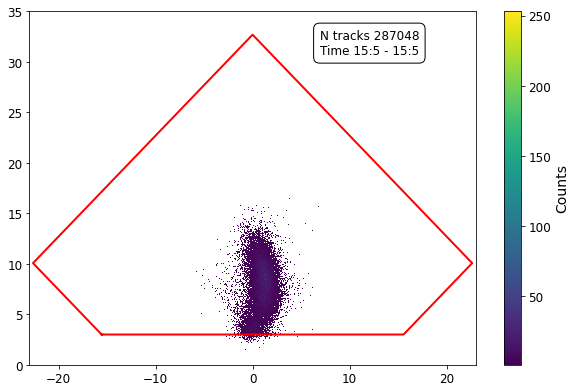

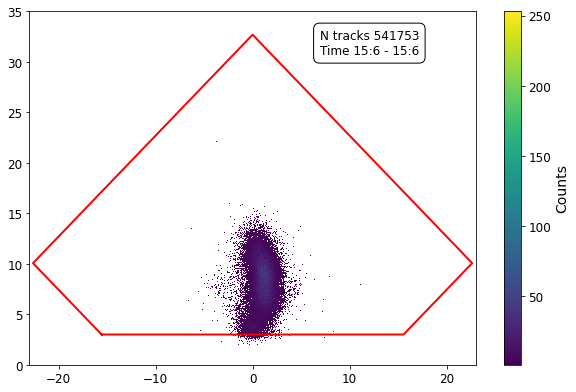

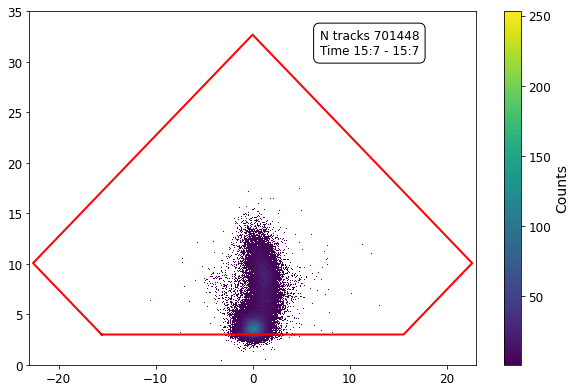

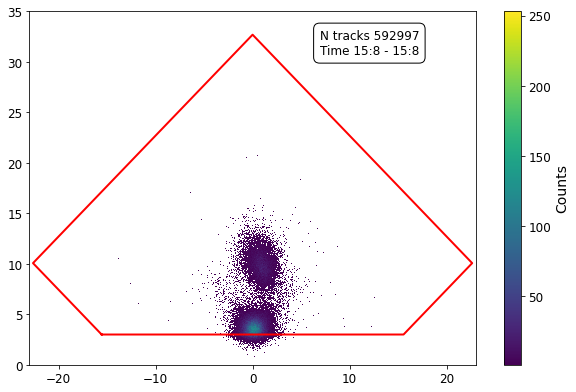

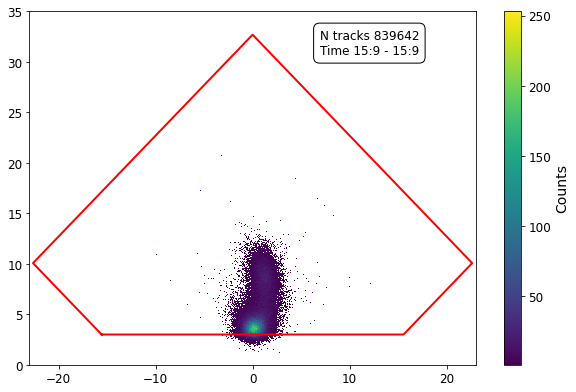

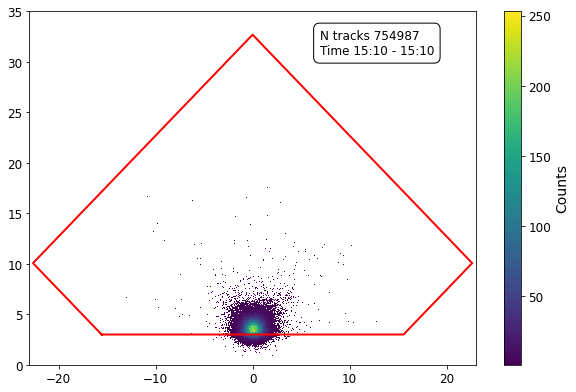

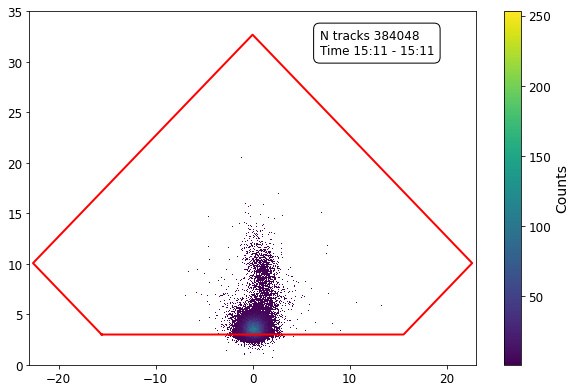

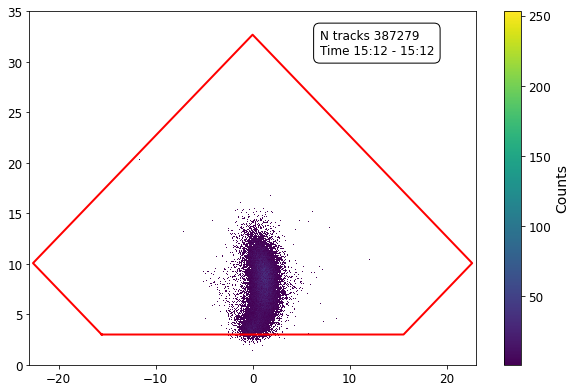

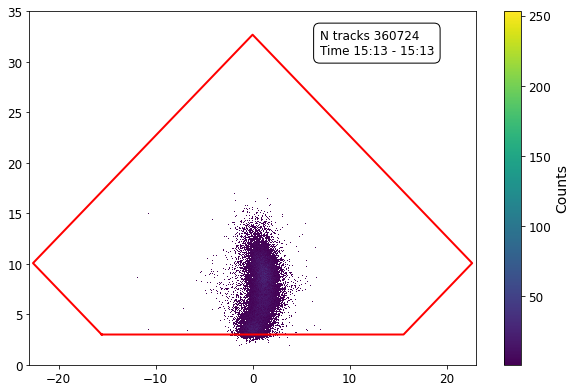

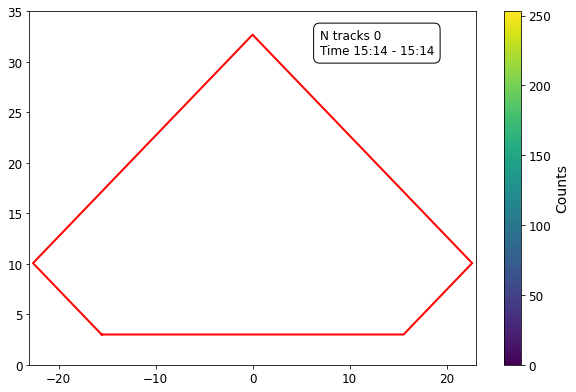

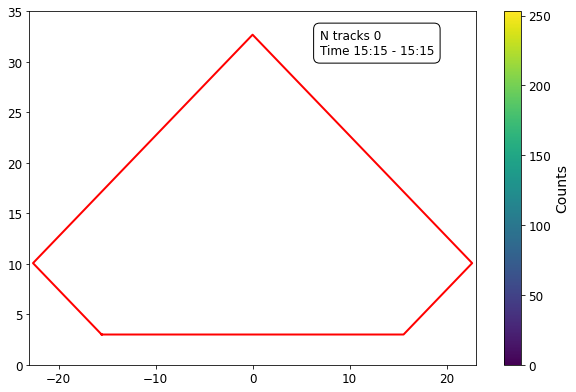

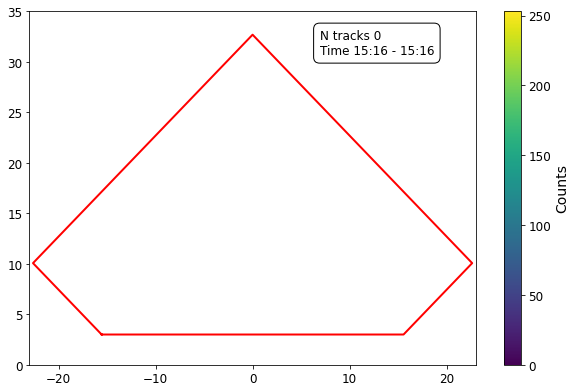

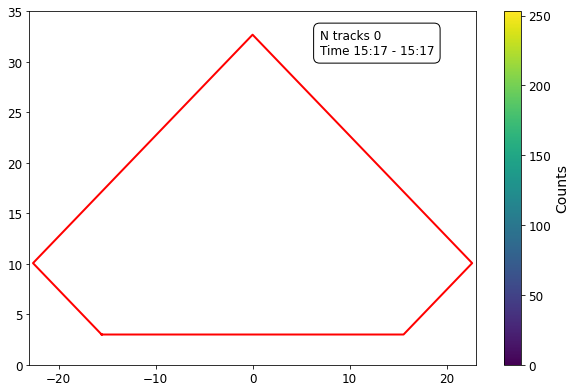

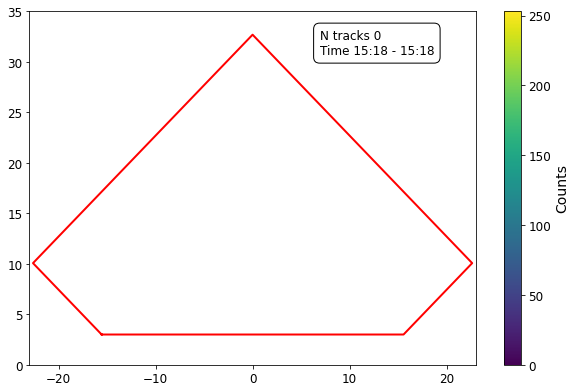

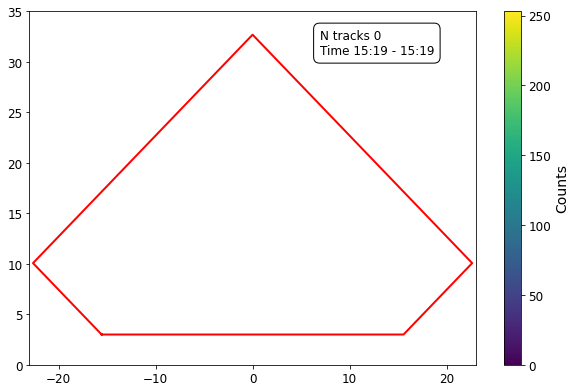

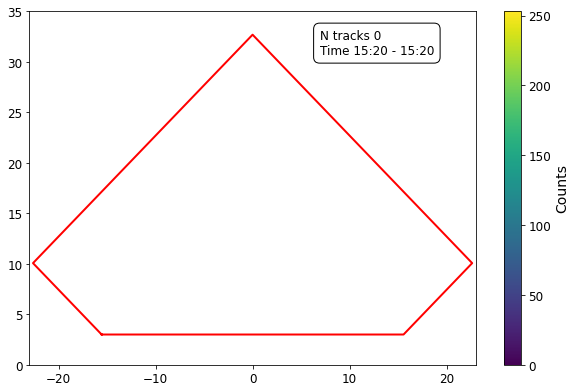

In [57]:
hour, minute = 14, 49
last_hour, last_minute = 15, 20

start = hour * 60 + minute
end = last_hour * 60 + last_minute


for t in range(start +1, end +1):
    h = t // 60
    m = t % 60

    plot_TFT_tracks((h, m), comulative = False, z_max = 253)


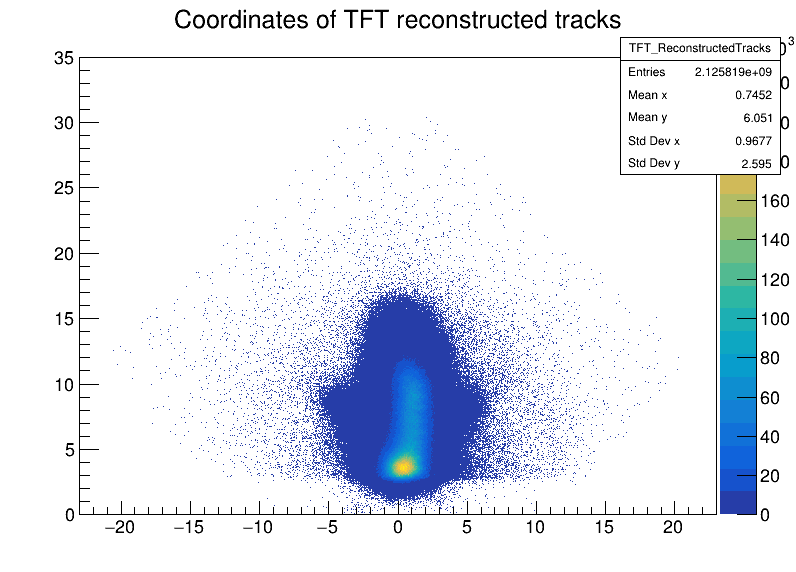

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2
Info in <TCanvas::Print>: png file tmp.png has been created


In [16]:
#file_name = './merged_gnams/TOTAL_gnam_1745130431.root'
folder_name = 'Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG/'
hist_name = 'TFT_ReconstructedTracks'

root_file = ROOT.TFile.Open(file_name)
hist = root_file.Get('Histogramming/TopMIG-OH_TFT_TDAQ_Slice/DEBUG').Get('TFT_ReconstructedTracks')
if not hist:
    print("Error: Histogram not found.")
else:
    canvas = ROOT.TCanvas("canvas2", "Histogram Canvas", 800, 600)
    hist.Draw("COLZ")
    canvas.Update()
    canvas.SaveAs("tmp.png")  # Save the histogram as a PNG
    display(Image(filename="tmp.png"))  # Show the image in Jupyter#

In [ ]:
TCCS.5R3.B2:Acquisition:controllerPosition_linear
#TCCS.5R3.B2:Acquisition:resolverPosition_linear  # same
#TCCS.5R3.B2:Acquisition:lvdtPosition_linear   # a little different


TCCS.5R3.B2:Acquisition:controllerPosition_rotational
#TCCS.5R3.B2:Acquisition:position_rotational  # same

TCCS.5R3.B2:Status:speed_rotational


#XRPV.B4L3.B2_SENSOR2:Acquisition:lvdtPosition
#XRPV.B4L3.B2:Acquisition:lvdtPosition
XRPV.B4L3.B2:Acquisition:controllerPosition
#XRPV.B4L3.B2:Acquisition:resolverPosition


TCLA.A5L3.B2:MEAS_MOTOR_LU
#TCLA.A5L3.B2:MEAS_MOTOR_LD
#TCLA.A5L3.B2:MEAS_MOTOR_RD
#TCLA.A5L3.B2:MEAS_MOTOR_RU


BLMTI.05R3.B2E10_TCCS.5R3.B2:LOSS_RS09  # Loss measurement for BLMTI.05R3.B2E10_TCCS.5R3.B2 with 1.31072s integration time

BLMTI.05L3.B2E10_TCLA.A5L3.B2:LOSS_RS09

BLMTI.04L3.B2E10_TCCP_XRPV:LOSS_RS09

BLMTI.04R7.B2I10_TCSG.A4R7.B2:LOSS_RS09


ADTV.SR4.B2:BLOWUP_RUNNING


SyntaxError: invalid syntax (3129279429.py, line 1)

total 79M
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:40 r1745147836_124-2025-04-20-17-40.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:39 r1745147836_124-2025-04-20-17-39.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:38 r1745147836_124-2025-04-20-17-38.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:37 r1745147836_124-2025-04-20-17-37.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:36 r1745147836_124-2025-04-20-17-36.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:35 r1745147836_124-2025-04-20-17-35.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:34 r1745147836_124-2025-04-20-17-34.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:33 r1745147836_124-2025-04-20-17-33.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:32 r1745147836_124-2025-04-20-17-32.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:31 r1745147836_124-2025-04-20-17-31.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:30 r1745147836_124-2025-04-20-17-30.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:29 r1745147836_124-2025-04-20-17-29.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:28 r1745147836_124-2025-04-20-17-27.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:26 r1745147836_124-2025-04-20-17-26.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:25 r1745147836_124-2025-04-20-17-25.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:24 r1745147836_124-2025-04-20-17-24.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:23 r1745147836_124-2025-04-20-17-23.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:22 r1745147836_124-2025-04-20-17-22.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:21 r1745147836_124-2025-04-20-17-21.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:20 r1745147836_124-2025-04-20-17-20.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:19 r1745147836_124-2025-04-20-17-19.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:18 r1745147836_124-2025-04-20-17-18.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:17 r1745147836_124-2025-04-20-17-17.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:16 r1745147836_124-2025-04-20-17-16.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:15 r1745147836_124-2025-04-20-17-15.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:14 r1745147836_124-2025-04-20-17-14.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:13 r1745147836_124-2025-04-20-17-13.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:12 r1745147836_124-2025-04-20-17-12.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:11 r1745147836_124-2025-04-20-17-11.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:10 r1745147836_124-2025-04-20-17-10.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:09 r1745147836_124-2025-04-20-17-09.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:08 r1745147836_124-2025-04-20-17-08.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:07 r1745147836_124-2025-04-20-17-07.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:06 r1745147836_124-2025-04-20-17-06.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:05 r1745147836_124-2025-04-20-17-05.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:04 r1745147836_124-2025-04-20-17-04.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:03 r1745147836_124-2025-04-20-17-03.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:02 r1745147836_124-2025-04-20-17-02.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:01 r1745147836_124-2025-04-20-17-01.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 17:00 r1745147836_124-2025-04-20-17-00.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:59 r1745147836_124-2025-04-20-16-59.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:58 r1745147836_124-2025-04-20-16-58.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:57 r1745147836_124-2025-04-20-16-57.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:56 r1745147836_124-2025-04-20-16-56.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:55 r1745147836_124-2025-04-20-16-55.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:54 r1745147836_124-2025-04-20-16-54.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:53 r1745147836_124-2025-04-20-16-53.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:52 r1745147836_124-2025-04-20-16-52.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:51 r1745147836_124-2025-04-20-16-51.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:50 r1745147836_124-2025-04-20-16-50.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:49 r1745147836_124-2025-04-20-16-49.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:48 r1745147836_124-2025-04-20-16-48.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:47 r1745147836_124-2025-04-20-16-47.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:46 r1745147836_124-2025-04-20-16-45.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:44 r1745147836_124-2025-04-20-16-44.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:43 r1745147836_124-2025-04-20-16-43.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:42 r1745147836_124-2025-04-20-16-42.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:41 r1745147836_124-2025-04-20-16-41.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:40 r1745147836_124-2025-04-20-16-40.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:39 r1745147836_124-2025-04-20-16-39.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:38 r1745147836_124-2025-04-20-16-38.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:37 r1745147836_124-2025-04-20-16-37.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:36 r1745147836_124-2025-04-20-16-36.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:35 r1745147836_124-2025-04-20-16-35.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:34 r1745147836_124-2025-04-20-16-34.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:33 r1745147836_124-2025-04-20-16-33.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:32 r1745147836_124-2025-04-20-16-32.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:31 r1745147836_124-2025-04-20-16-31.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:30 r1745147836_124-2025-04-20-16-30.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:29 r1745147836_124-2025-04-20-16-29.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:28 r1745147836_124-2025-04-20-16-28.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:27 r1745147836_124-2025-04-20-16-27.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:26 r1745147836_124-2025-04-20-16-26.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:25 r1745147836_124-2025-04-20-16-25.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:24 r1745147836_124-2025-04-20-16-24.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:23 r1745147836_124-2025-04-20-16-23.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:22 r1745147836_124-2025-04-20-16-22.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:21 r1745147836_124-2025-04-20-16-21.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:20 r1745147836_124-2025-04-20-16-20.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:19 r1745147836_124-2025-04-20-16-19.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:18 r1745147836_124-2025-04-20-16-18.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:17 r1745147836_124-2025-04-20-16-17.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:16 r1745147836_124-2025-04-20-16-16.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:15 r1745147836_124-2025-04-20-16-15.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:14 r1745147836_124-2025-04-20-16-14.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:13 r1745147836_124-2025-04-20-16-13.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:12 r1745147836_124-2025-04-20-16-12.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:11 r1745147836_124-2025-04-20-16-11.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:10 r1745147836_124-2025-04-20-16-10.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:09 r1745147836_124-2025-04-20-16-09.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:08 r1745147836_124-2025-04-20-16-08.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:07 r1745147836_124-2025-04-20-16-07.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:06 r1745147836_124-2025-04-20-16-06.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:05 r1745147836_124-2025-04-20-16-05.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:04 r1745147836_124-2025-04-20-16-04.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:03 r1745147836_124-2025-04-20-16-02.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:01 r1745147836_124-2025-04-20-16-01.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 16:00 r1745147836_124-2025-04-20-16-00.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:59 r1745147836_124-2025-04-20-15-59.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:58 r1745147836_124-2025-04-20-15-58.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:57 r1745147836_124-2025-04-20-15-57.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:56 r1745147836_124-2025-04-20-15-56.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:55 r1745147836_124-2025-04-20-15-55.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:54 r1745147836_124-2025-04-20-15-54.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:53 r1745147836_124-2025-04-20-15-53.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:52 r1745147836_124-2025-04-20-15-52.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:51 r1745147836_124-2025-04-20-15-51.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:50 r1745147836_124-2025-04-20-15-50.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:49 r1745147836_124-2025-04-20-15-49.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:48 r1745147836_124-2025-04-20-15-48.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:47 r1745147836_124-2025-04-20-15-47.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:46 r1745147836_124-2025-04-20-15-46.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:45 r1745147836_124-2025-04-20-15-45.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:44 r1745147836_124-2025-04-20-15-44.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:43 r1745147836_124-2025-04-20-15-43.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:42 r1745147836_124-2025-04-20-15-42.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:41 r1745147836_124-2025-04-20-15-41.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:40 r1745147836_124-2025-04-20-15-40.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:39 r1745147836_124-2025-04-20-15-39.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:38 r1745147836_124-2025-04-20-15-38.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:37 r1745147836_124-2025-04-20-15-37.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:36 r1745147836_124-2025-04-20-15-36.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:35 r1745147836_124-2025-04-20-15-35.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:34 r1745147836_124-2025-04-20-15-34.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:33 r1745147836_124-2025-04-20-15-33.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:32 r1745147836_124-2025-04-20-15-32.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:31 r1745147836_124-2025-04-20-15-31.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:30 r1745147836_124-2025-04-20-15-30.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:29 r1745147836_124-2025-04-20-15-29.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:28 r1745147836_124-2025-04-20-15-28.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:27 r1745147836_124-2025-04-20-15-27.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:26 r1745147836_124-2025-04-20-15-26.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:25 r1745147836_124-2025-04-20-15-25.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:24 r1745147836_124-2025-04-20-15-24.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:23 r1745147836_124-2025-04-20-15-23.root
-rw-r--r-- 1 korcyl zp 380K Apr 20 15:22 r1745147836_124-2025-04-20-15-22.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:21 r1745147836_124-2025-04-20-15-20.root # very out
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:19 r1745147836_123-2025-04-20-15-19.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:18 r1745147836_122-2025-04-20-15-18.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:17 r1745147836_121-2025-04-20-15-17.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:16 r1745147836_120-2025-04-20-15-16.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:15 r1745147836_119-2025-04-20-15-15.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:14 r1745147836_118-2025-04-20-15-14.root  # out

-rw-r--r-- 1 korcyl zp 382K Apr 20 15:13 r1745147836_117-2025-04-20-15-13.root  # last 
-rw-r--r-- 1 korcyl zp 399K Apr 20 15:12 r1745147836_116-2025-04-20-15-12.root
-rw-r--r-- 1 korcyl zp 397K Apr 20 15:11 r1745147836_115-2025-04-20-15-11.root
-rw-r--r-- 1 korcyl zp 386K Apr 20 15:10 r1745147836_114-2025-04-20-15-10.root
-rw-r--r-- 1 korcyl zp 381K Apr 20 15:09 r1745147836_113-2025-04-20-15-09.root
-rw-r--r-- 1 korcyl zp 367K Apr 20 15:08 r1745147836_112-2025-04-20-15-08.root
-rw-r--r-- 1 korcyl zp 373K Apr 20 15:07 r1745147836_111-2025-04-20-15-07.root
-rw-r--r-- 1 korcyl zp 378K Apr 20 15:06 r1745147836_109-2025-04-20-15-06.root
-rw-r--r-- 1 korcyl zp 372K Apr 20 15:05 r1745147836_108-2025-04-20-15-05.root
-rw-r--r-- 1 korcyl zp 371K Apr 20 15:04 r1745147836_107-2025-04-20-15-04.root
-rw-r--r-- 1 korcyl zp 364K Apr 20 15:03 r1745147836_106-2025-04-20-15-03.root
-rw-r--r-- 1 korcyl zp 355K Apr 20 15:02 r1745147836_105-2025-04-20-15-02.root
-rw-r--r-- 1 korcyl zp 333K Apr 20 15:01 r1745147836_104-2025-04-20-15-01.root
-rw-r--r-- 1 korcyl zp 329K Apr 20 15:00 r1745147836_103-2025-04-20-15-00.root
-rw-r--r-- 1 korcyl zp 323K Apr 20 14:59 r1745147836_102-2025-04-20-14-59.root
-rw-r--r-- 1 korcyl zp 327K Apr 20 14:58 r1745147836_101-2025-04-20-14-58.root
-rw-r--r-- 1 korcyl zp 324K Apr 20 14:57 r1745147836_100-2025-04-20-14-57.root
-rw-r--r-- 1 korcyl zp 298K Apr 20 14:56 r1745147836_99-2025-04-20-14-56.root
-rw-r--r-- 1 korcyl zp 280K Apr 20 14:55 r1745147836_98-2025-04-20-14-55.root
-rw-r--r-- 1 korcyl zp 254K Apr 20 14:54 r1745147836_97-2025-04-20-14-54.root
-rw-r--r-- 1 korcyl zp 227K Apr 20 14:53 r1745147836_96-2025-04-20-14-53.root
-rw-r--r-- 1 korcyl zp 205K Apr 20 14:52 r1745147836_95-2025-04-20-14-52.root
-rw-r--r-- 1 korcyl zp 180K Apr 20 14:51 r1745147836_94-2025-04-20-14-51.root
-rw-r--r-- 1 korcyl zp 155K Apr 20 14:50 r1745147836_93-2025-04-20-14-50.root
-rw-r--r-- 1 korcyl zp 143K Apr 20 14:49 r1745147836_92-2025-04-20-14-49.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 14:48 r1745147836_91-2025-04-20-14-48.root  # XRP 20 mm 

-rw-r--r-- 1 korcyl zp 122K Apr 20 14:47 r1745147836_90-2025-04-20-14-47.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 14:46 r1745147836_89-2025-04-20-14-46.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 14:45 r1745147836_88-2025-04-20-14-45.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 14:44 r1745147836_87-2025-04-20-14-44.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 14:43 r1745147836_86-2025-04-20-14-42.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:41 r1745147836_85-2025-04-20-14-41.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:40 r1745147836_84-2025-04-20-14-40.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:39 r1745147836_83-2025-04-20-14-39.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:38 r1745147836_82-2025-04-20-14-38.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:37 r1745147836_81-2025-04-20-14-37.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 14:36 r1745147836_80-2025-04-20-14-36.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 14:35 r1745147836_79-2025-04-20-14-35.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 14:34 r1745147836_78-2025-04-20-14-34.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 14:33 r1745147836_77-2025-04-20-14-33.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 14:32 r1745147836_76-2025-04-20-14-32.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 14:31 r1745147836_75-2025-04-20-14-31.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 14:30 r1745147836_74-2025-04-20-14-30.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 14:29 r1745147836_73-2025-04-20-14-29.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 14:28 r1745147836_72-2025-04-20-14-28.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 14:27 r1745147836_71-2025-04-20-14-27.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 14:26 r1745147836_70-2025-04-20-14-26.root
-rw-r--r-- 1 korcyl zp 113K Apr 20 14:25 r1745147836_68-2025-04-20-14-25.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 14:24 r1745147836_67-2025-04-20-14-24.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 14:23 r1745147836_66-2025-04-20-14-23.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 14:22 r1745147836_65-2025-04-20-14-22.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 14:21 r1745147836_64-2025-04-20-14-21.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 14:20 r1745147836_63-2025-04-20-14-20.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:19 r1745147836_62-2025-04-20-14-19.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:18 r1745147836_61-2025-04-20-14-18.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:17 r1745147836_60-2025-04-20-14-17.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:16 r1745147836_59-2025-04-20-14-16.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:15 r1745147836_58-2025-04-20-14-15.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:14 r1745147836_57-2025-04-20-14-14.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:13 r1745147836_56-2025-04-20-14-13.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:12 r1745147836_55-2025-04-20-14-12.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 14:11 r1745147836_54-2025-04-20-14-11.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:10 r1745147836_53-2025-04-20-14-10.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:09 r1745147836_52-2025-04-20-14-09.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:08 r1745147836_51-2025-04-20-14-08.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:07 r1745147836_50-2025-04-20-14-07.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:06 r1745147836_49-2025-04-20-14-06.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:05 r1745147836_48-2025-04-20-14-05.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:04 r1745147836_47-2025-04-20-14-03.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:02 r1745147836_46-2025-04-20-14-02.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 14:01 r1745147836_45-2025-04-20-14-01.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 14:00 r1745147836_44-2025-04-20-14-00.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:59 r1745147836_43-2025-04-20-13-59.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:58 r1745147836_42-2025-04-20-13-58.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:57 r1745147836_41-2025-04-20-13-57.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:56 r1745147836_40-2025-04-20-13-56.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:55 r1745147836_39-2025-04-20-13-55.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:54 r1745147836_38-2025-04-20-13-54.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:53 r1745147836_37-2025-04-20-13-53.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:52 r1745147836_36-2025-04-20-13-52.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:51 r1745147836_35-2025-04-20-13-51.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:50 r1745147836_34-2025-04-20-13-50.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:49 r1745147836_33-2025-04-20-13-49.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 13:48 r1745147836_32-2025-04-20-13-48.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:47 r1745147836_31-2025-04-20-13-47.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:46 r1745147836_30-2025-04-20-13-46.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:45 r1745147836_29-2025-04-20-13-45.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:44 r1745147836_28-2025-04-20-13-44.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:43 r1745147836_26-2025-04-20-13-43.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:42 r1745147836_25-2025-04-20-13-42.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:41 r1745147836_24-2025-04-20-13-41.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:40 r1745147836_23-2025-04-20-13-40.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:39 r1745147836_22-2025-04-20-13-39.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 13:38 r1745147836_21-2025-04-20-13-38.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:37 r1745147836_20-2025-04-20-13-37.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:36 r1745147836_19-2025-04-20-13-36.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:35 r1745147836_18-2025-04-20-13-35.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:34 r1745147836_17-2025-04-20-13-34.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:33 r1745147836_16-2025-04-20-13-33.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:32 r1745147836_15-2025-04-20-13-32.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:31 r1745147836_14-2025-04-20-13-31.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:30 r1745147836_13-2025-04-20-13-30.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 13:29 r1745147836_12-2025-04-20-13-29.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:28 r1745147836_11-2025-04-20-13-28.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:27 r1745147836_10-2025-04-20-13-27.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:26 r1745147836_9-2025-04-20-13-26.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:25 r1745147836_8-2025-04-20-13-25.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:24 r1745147836_7-2025-04-20-13-23.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 13:22 r1745147836_6-2025-04-20-13-22.root
-rw-r--r-- 1 korcyl zp 105K Apr 20 13:21 r1745147836_5-2025-04-20-13-21.root
-rw-r--r-- 1 korcyl zp 105K Apr 20 13:20 r1745147836_4-2025-04-20-13-20.root
-rw-r--r-- 1 korcyl zp 105K Apr 20 13:19 r1745147836_3-2025-04-20-13-19.root
-rw-r--r-- 1 korcyl zp 104K Apr 20 13:18 r1745147836_2-2025-04-20-13-18.root
-rw-r--r-- 1 korcyl zp 104K Apr 20 13:17 r1745147836_1-2025-04-20-13-17.root




-rw-r--r-- 1 korcyl zp 121K Apr 20 13:16 r1745142439_85-2025-04-20-13-16.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:15 r1745142439_85-2025-04-20-13-15.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:14 r1745142439_85-2025-04-20-13-14.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:13 r1745142439_85-2025-04-20-13-13.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:12 r1745142439_85-2025-04-20-13-12.root
-rw-r--r-- 1 korcyl zp 122K Apr 20 13:11 r1745142439_85-2025-04-20-13-11.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:10 r1745142439_83-2025-04-20-13-10.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:09 r1745142439_82-2025-04-20-13-09.root
-rw-r--r-- 1 korcyl zp 121K Apr 20 13:08 r1745142439_81-2025-04-20-13-08.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 13:07 r1745142439_80-2025-04-20-13-07.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 13:06 r1745142439_79-2025-04-20-13-06.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 13:05 r1745142439_78-2025-04-20-13-05.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 13:04 r1745142439_77-2025-04-20-13-04.root
-rw-r--r-- 1 korcyl zp 120K Apr 20 13:03 r1745142439_76-2025-04-20-13-03.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 13:02 r1745142439_75-2025-04-20-13-02.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 13:01 r1745142439_74-2025-04-20-13-01.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 13:00 r1745142439_73-2025-04-20-13-00.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 12:59 r1745142439_72-2025-04-20-12-59.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 12:58 r1745142439_71-2025-04-20-12-58.root
-rw-r--r-- 1 korcyl zp 119K Apr 20 12:57 r1745142439_70-2025-04-20-12-57.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 12:56 r1745142439_69-2025-04-20-12-56.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 12:55 r1745142439_68-2025-04-20-12-55.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 12:54 r1745142439_67-2025-04-20-12-54.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 12:53 r1745142439_66-2025-04-20-12-53.root
-rw-r--r-- 1 korcyl zp 118K Apr 20 12:52 r1745142439_65-2025-04-20-12-52.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 12:51 r1745142439_64-2025-04-20-12-51.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 12:50 r1745142439_63-2025-04-20-12-50.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 12:49 r1745142439_62-2025-04-20-12-49.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 12:48 r1745142439_61-2025-04-20-12-48.root
-rw-r--r-- 1 korcyl zp 117K Apr 20 12:47 r1745142439_60-2025-04-20-12-47.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 12:46 r1745142439_59-2025-04-20-12-45.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 12:44 r1745142439_58-2025-04-20-12-44.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 12:43 r1745142439_57-2025-04-20-12-43.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 12:42 r1745142439_56-2025-04-20-12-42.root
-rw-r--r-- 1 korcyl zp 116K Apr 20 12:41 r1745142439_55-2025-04-20-12-41.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 10:46 r1745138178_11-2025-04-20-10-46.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 10:45 r1745138178_10-2025-04-20-10-45.root
-rw-r--r-- 1 korcyl zp 112K Apr 20 10:44 r1745138178_9-2025-04-20-10-44.root
-rw-r--r-- 1 korcyl zp 111K Apr 20 10:43 r1745138178_8-2025-04-20-10-43.root
-rw-r--r-- 1 korcyl zp 110K Apr 20 10:42 r1745138178_7-2025-04-20-10-42.root
-rw-r--r-- 1 korcyl zp 109K Apr 20 10:41 r1745138178_6-2025-04-20-10-41.root
-rw-r--r-- 1 korcyl zp 108K Apr 20 10:40 r1745138178_5-2025-04-20-10-40.root
-rw-r--r-- 1 korcyl zp 107K Apr 20 10:39 r1745138178_4-2025-04-20-10-39.root
-rw-r--r-- 1 korcyl zp 106K Apr 20 10:38 r1745138178_3-2025-04-20-10-38.root
-rw-r--r-- 1 korcyl zp 105K Apr 20 10:37 r1745138178_1-2025-04-20-10-37.root
-rw-r--r-- 1 korcyl zp 104K Apr 20 10:36 r1745138178_0-2025-04-20-10-36.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:35 r1745130431_124-2025-04-20-10-35.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:34 r1745130431_124-2025-04-20-10-34.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:33 r1745130431_124-2025-04-20-10-33.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:32 r1745130431_124-2025-04-20-10-32.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:31 r1745130431_124-2025-04-20-10-31.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:30 r1745130431_123-2025-04-20-10-30.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:29 r1745130431_122-2025-04-20-10-29.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:28 r1745130431_121-2025-04-20-10-28.root
-rw-r--r-- 1 korcyl zp 115K Apr 20 10:27 r1745130431_120-2025-04-20-10-27.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:26 r1745130431_119-2025-04-20-10-26.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:25 r1745130431_118-2025-04-20-10-25.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:24 r1745130431_117-2025-04-20-10-24.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:23 r1745130431_116-2025-04-20-10-23.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:22 r1745130431_115-2025-04-20-10-22.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:21 r1745130431_114-2025-04-20-10-21.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:20 r1745130431_113-2025-04-20-10-20.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:19 r1745130431_112-2025-04-20-10-18.root
-rw-r--r-- 1 korcyl zp 114K Apr 20 10:17 r1745130431_111-2025-04-20-10-17.root
